In [1]:
import tweepy
from pymongo import MongoClient
from nltk.corpus import stopwords
import json
import re
import string
import pandas as pd
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

consumer_key = "POA1eXAkYisz3kBRdcmjeBcha"
consumer_secret = "Ol97n9dfJcSiHvxUmPfRoR7QcLBMzuM5MdOrG36dBuNyT2EzNw"
access_token = "354671169-ROmqMvVamNyggX9hqNzlpqhTgc6AkCOpT6bsjodA"
access_secret = "RqlakpclhdjQzijYhaSfqqK0Yhzv3AZe6RdQggdms8sYn"
 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.secure = True
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

client = MongoClient('localhost', 27017)
db = client.bigData

In [4]:
count  = 0
class MyStreamListener(tweepy.StreamListener):
    
    print('func called')
        
    def on_data(self, data):
        global count 
        # Decode JSON
        client = MongoClient('localhost', 27017)
        db = client.bigData
        
        datajson = json.loads(data)
        data_insert = {'tweet_text': datajson['text']}
        db.tweetIndiaUL.insert(data_insert)
        print("inserted ",count )
        count +=1
        if count  > 500 : 
            return false
myStreamListener = MyStreamListener()

myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

GEOBOX_WORLD = [-180,-90,180,90]
#format = [leftLimit   lowerLimit    rightLimit     upperLimit]

GEOBOX_INDIA = [71.1924, 8.0883,94.7278, 33.7782]

GEOBOX_INDIA_UPPER_LEFT = [69.17, 19.93, 79.72, 35.28]
GEOBOX_INDIA_UPPER_RIGHT = [69.17, 19.93, 79.72, 35.28]
GEOBOX_INDIA_LOWER = [68.11,8.02,89.91,23.12]
myStream.filter(locations = GEOBOX_INDIA_UPPER_LEFT)
#myStream.filter(locations = GEOBOX_INDIA_UPPER_RIGHT)
#myStream.filter(locations = GEOBOX_INDIA_LOWER)

func called


NameError: name 'api' is not defined

In [3]:
def clean_text(text):
    text = text.encode('ascii', 'ignore')
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

In [4]:
def find_tweets(location):
    cursor = []
    if location == 'IndiaUL':
        cursor  = db.tweetIndiaUL.find({})
    if location == 'IndiaUR':
        cursor  = db.tweetIndiaUR.find({})
    if location == 'IndiaLC':
        cursor = db.tweetIndiaLC.find({})
    print cursor
        
    tweet_fields = ['tweet_text']
    docs = pd.DataFrame(list(cursor), columns = tweet_fields)
    docs  = docs['tweet_text'].tolist()
    print len(docs)
    return docs

In [5]:
ultweets =  find_tweets('IndiaUL')
ultweets = [clean_text(tweet) for tweet in ultweets]
final_ultweets = []
for tweet in ultweets:
    filtered_words = [word for word in tweet.split(' ') if word not in stopwords.words('english')]
    #print filtered_words
    new_tweet = ' '.join(filtered_words)
    final_ultweets.append(new_tweet)

print len(final_ultweets)

100
100


In [6]:
urtweets =  find_tweets('IndiaUR')
urtweets = [clean_text(tweet) for tweet in urtweets]
final_urtweets = []
for tweet in urtweets:
    filtered_words = [word for word in tweet.split(' ') if word not in stopwords.words('english')]
    #print filtered_words
    new_tweet = ' '.join(filtered_words)
    final_urtweets.append(new_tweet)

print len(final_urtweets)

233
233


In [7]:
lctweets =  find_tweets('IndiaLC')
lctweets = [clean_text(tweet) for tweet in lctweets]
final_lctweets = []
for tweet in lctweets:
    filtered_words = [word for word in tweet.split(' ') if word not in stopwords.words('english')]
    #print filtered_words

    new_tweet = ' '.join(filtered_words)
    final_lctweets.append(new_tweet)

print len(final_lctweets)

382
382


In [8]:
import textmining
import lda
model = lda.LDA(n_topics=5 , n_iter=150 , random_state=1)
import numpy as np

def termdocumentmatrix_example(docs):
    # Create some very short sample documents
    tdm = textmining.TermDocumentMatrix()
    for doc in docs:
        tdm.add_doc(doc)
    
    
    dtrow= []
    cnt = 0 
    for row in tdm.rows(cutoff=2):
        if cnt == 0 :
            vocab = row
        else:
            dtrow.append(row)
        #print row
        cnt+=1
    dtrow = np.array(dtrow)
    return vocab,dtrow
vocab1, dtrow1 =  termdocumentmatrix_example(final_ultweets)
vocab2, dtrow2 =  termdocumentmatrix_example(final_urtweets)
vocab3, dtrow3 =  termdocumentmatrix_example(final_lctweets)

In [9]:
model = lda.LDA(n_topics=5, n_iter= 60 , random_state=1)

model.fit(dtrow1)

topic_word = model.topic_word_
n_top_words = 5
writeText1 = ' '
writeText1 = 'Trending topics  from North Right part of India \n '

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab1)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    writeText1 = writeText1 + 'Topic: ' + ' '.join(topic_words)
    writeText1 = writeText1 + '\n'

    
    
    
model = lda.LDA(n_topics=5, n_iter= 60 , random_state=1)

model.fit(dtrow2)

topic_word = model.topic_word_
n_top_words = 5
writeText2 = ' '
writeText2 = 'Trending topics from North Left part of India \n '

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab2)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    writeText2 = writeText2 + 'Topic: '+' '.join(topic_words)
    writeText2 = writeText2 + '\n'

    
    
    
model = lda.LDA(n_topics=5, n_iter= 60 , random_state=1)

model.fit(dtrow3)

topic_word = model.topic_word_
n_top_words = 5
writeText3 = 'Trending topics from South part of India \n'
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab3)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    writeText3 = writeText3 +'Topic: '+ ' '.join(topic_words)
    writeText3 = writeText3 + '\n'


INFO:lda:n_documents: 100
INFO:lda:vocab_size: 105
INFO:lda:n_words: 356
INFO:lda:n_topics: 5
INFO:lda:n_iter: 60
INFO:lda:<0> log likelihood: -3241
INFO:lda:<10> log likelihood: -1960
INFO:lda:<20> log likelihood: -1931
INFO:lda:<30> log likelihood: -1882
INFO:lda:<40> log likelihood: -1871
INFO:lda:<50> log likelihood: -1839
INFO:lda:<59> log likelihood: -1816
INFO:lda:n_documents: 233
INFO:lda:vocab_size: 227
INFO:lda:n_words: 668
INFO:lda:n_topics: 5
INFO:lda:n_iter: 60
INFO:lda:<0> log likelihood: -6620


Topic 0: via foxnews secio android app
Topic 1: you arvindkejriwal the school whenlifestuck
Topic 2: rdposter jattuengineer gurmeetramrahim amp poster
Topic 3: justice it world get nationawaitsfairinquiry
Topic 4: i s m endomondo km


INFO:lda:<10> log likelihood: -4413
INFO:lda:<20> log likelihood: -4315
INFO:lda:<30> log likelihood: -4240
INFO:lda:<40> log likelihood: -4187
INFO:lda:<50> log likelihood: -4172
INFO:lda:<59> log likelihood: -4134
INFO:lda:n_documents: 382
INFO:lda:vocab_size: 422
INFO:lda:n_words: 1508
INFO:lda:n_topics: 5
INFO:lda:n_iter: 60
INFO:lda:<0> log likelihood: -15538


Topic 0: main k st army amp
Topic 1: narendramodi modicheatshimachal secio mein amitshah
Topic 2: tradingtips stockstowatch business got trump
Topic 3: g good himachal gurmeetramrahim india
Topic 4: i time life in s


INFO:lda:<10> log likelihood: -10513
INFO:lda:<20> log likelihood: -10231
INFO:lda:<30> log likelihood: -10080
INFO:lda:<40> log likelihood: -9997
INFO:lda:<50> log likelihood: -9997
INFO:lda:<59> log likelihood: -9992


Topic 0: i good morning m gt
Topic 1: rs may apr line t
Topic 2: u property in a forsale
Topic 3: narendramodi baahubali we hi job
Topic 4: s amp it modicheatshimachal india


In [11]:
import math
from nltk.corpus import stopwords
import re
cachedStopWords = stopwords.words("english")
from __future__ import division, unicode_literals
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)) + 0.000001)

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [12]:
cursor  = db.tweetIndiaUL.find({})
tweetDocUL  =list(cursor)
tweetDocUL = [  clean_text(tweet['tweet_text']) for tweet in tweetDocUL ] 
tweetDocUL = ' '.join(tweetDocUL)
tweetDocUL = tb(tweetDocUL)

cursor  = db.tweetIndiaUR.find({})
tweetDocUR  =list(cursor)
tweetDocUR = [  clean_text(tweet['tweet_text']) for tweet in tweetDocUR ] 
tweetDocUR = ' '.join(tweetDocUR)
tweetDocUR = tb(tweetDocUR)

cursor  = db.tweetIndiaLC.find({})
tweetDocLC  =list(cursor)
tweetDocLC = [  clean_text(tweet['tweet_text']) for tweet in tweetDocLC ] 
tweetDocLC = ' '.join(tweetDocLC)
tweetDocLC = tb(tweetDocLC)

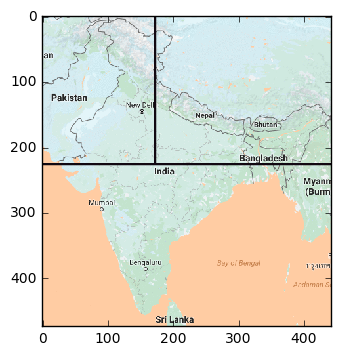

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread('req.png')  

plt.imshow(image, interpolation='nearest')
#plt.draw()
#plt.savefig('req.png', dpi=200)
plt.show()


In [13]:
bloblist = [tweetDocUL, tweetDocUR,tweetDocLC]
filenames = ['India Upper Left','India Upper Right','India Lower Combined']
for i, blob in enumerate(bloblist):
    print("Top words in document {}".format( filenames[i]))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:15]:
        
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in document India Upper Left
	Word: i, TF-IDF: 0.00559
	Word: jattuengineer3rdposter, TF-IDF: 0.0043
	Word: Justice, TF-IDF: 0.00301
	Word: justice, TF-IDF: 0.00301
	Word: NationAwaitsFairInquiry, TF-IDF: 0.00172
	Word: OM, TF-IDF: 0.00172
	Word: poster, TF-IDF: 0.00172
	Word: conscience, TF-IDF: 0.00129
	Word: school, TF-IDF: 0.00129
	Word: looking, TF-IDF: 0.00129
	Word: Even, TF-IDF: 0.00129
	Word: will, TF-IDF: 0.00129
	Word: WhenLifeStuck, TF-IDF: 0.00129
	Word: walking, TF-IDF: 0.00129
	Word: Beautiful, TF-IDF: 0.00129
Top words in document India Upper Right
	Word: G, TF-IDF: 0.00211
	Word: g, TF-IDF: 0.00211
	Word: life, TF-IDF: 0.00211
	Word: Life, TF-IDF: 0.00211
	Word: Bless, TF-IDF: 0.00132
	Word: Main, TF-IDF: 0.00132
	Word: bless, TF-IDF: 0.00132
	Word: Tradingtips, TF-IDF: 0.00106
	Word: 15NBMoMSME, TF-IDF: 0.00106
	Word: TradingTips, TF-IDF: 0.00106
	Word: man, TF-IDF: 0.00106
	Word: HMOIndia, TF-IDF: 0.00106
	Word: dhan, TF-IDF: 0.00106
	Word: MyMSMEApp, TF-ID

In [14]:
print writeText1
print writeText2
print writeText3

Trending topics  from North Right part of India 
 Topic: via foxnews secio android app
Topic: you arvindkejriwal the school whenlifestuck
Topic: rdposter jattuengineer gurmeetramrahim amp poster
Topic: justice it world get nationawaitsfairinquiry
Topic: i s m endomondo km

Trending topics from North Left part of India 
 Topic: main k st army amp
Topic: narendramodi modicheatshimachal secio mein amitshah
Topic: tradingtips stockstowatch business got trump
Topic: g good himachal gurmeetramrahim india
Topic: i time life in s

Trending topics from South part of India 
Topic: i good morning m gt
Topic: rs may apr line t
Topic: u property in a forsale
Topic: narendramodi baahubali we hi job
Topic: s amp it modicheatshimachal india

